In [81]:
# We set the backend to TensorFlow. The code works with
# both `tensorflow` and `torch`. It does not work with JAX
# due to the behavior of `jax.numpy.tile` in a jit scope
# (used in `TransformerDecoder.get_causal_attention_mask()`:
# `tile` in JAX does not support a dynamic `reps` argument.
# You can make the code work in JAX by wrapping the
# inside of the `get_causal_attention_mask` method in
# a decorator to prevent jit compilation:
# `with jax.ensure_compile_time_eval():`.
import os

os.environ["KERAS_BACKEND"] = "tensorflow"


import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings
import tensorflow_datasets.public_api as tfds

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization

In [82]:
text_pairs = []

with open("data.tsv", "r", encoding="utf-8") as f:
    for line in f:
        # Strip any extra whitespace and split the line by tabs
        fields = line.strip().split("\t")
        # Ensure the line has at least 4 fields (indexes 0 to 3)
        if len(fields) < 4:
            continue
        french = fields[1]  # second column
        portuguese = "[start] " + fields[3] + " [end]"  # fourth column
        text_pairs.append((french, portuguese))

# Print the first pair to verify
print(text_pairs[0])


('Je ne supporte pas ce type.', '[start] Eu não suporto esse tipo. [end]')


In [83]:
for _ in range(5):
    print(random.choice(text_pairs))

('En France, la majorité est fixée à 18 ans.', '[start] Em França, a maioridade está fixada nos 18 anos. [end]')
("Je veux quelqu'un qui sache parler français.", '[start] Quero alguém que saiba falar francês. [end]')
('As-tu déjà fini tes devoirs\u202f?', '[start] Você já terminou os seus deveres? [end]')
("Il vint au Japon alors qu'il n'avait que dix ans.", '[start] Ele veio ao Japão quando tinha apenas dez anos. [end]')
('Est-ce que tu as vu mon manteau ?', '[start] Você viu o meu paletó? [end]')


In [84]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

33030 total pairs
23122 training pairs
4954 validation pairs
4954 test pairs


In [85]:
strip_chars = string.punctuation + "«" + "»"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 25000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


french_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
portuguese_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_french_texts = [pair[0] for pair in train_pairs]
train_portuguese_texts = [pair[1] for pair in train_pairs]
french_vectorization.adapt(train_french_texts)
portuguese_vectorization.adapt(train_portuguese_texts)

In [86]:
def format_dataset(french, portuguese):
    french = french_vectorization(french)
    portuguese = portuguese_vectorization(portuguese)
    return (
        {
            "encoder_inputs": french,
            "decoder_inputs": portuguese[:, :-1],
        },
        portuguese[:, 1:],
    )


def make_dataset(pairs):
    french_texts, portuguese_texts = zip(*pairs)
    french_texts = list(french_texts)
    portuguese_texts = list(portuguese_texts)
    dataset = tf_data.Dataset.from_tensor_slices((french_texts, portuguese_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [87]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


2025-02-08 02:06:02.251372: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [88]:
print(train_french_texts[:5])
print(train_portuguese_texts[:5])

['Je veux suivre leurs traces.', "S'il te plaît, donne-moi de l'eau.", 'Viens si tu peux\u202f!', "Il n'est pas nécessaire de prendre tous ces médicaments.", 'Tout le monde était fatigué.']
['[start] Quero seguir os rastros deles. [end]', '[start] Por favor, dê-me um pouco de água! [end]', '[start] Venha se puder! [end]', '[start] Não é necessário tomar todos esses medicamentos. [end]', '[start] Todos estavam cansados. [end]']


In [89]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Parameters
sequence_length = 20  # Maximum number of tokens per sequence
vocab_size = 15000    # Total number of tokens in your vocabulary
embed_dim = 128       # Dimension of each token embedding

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        # Get token embeddings: shape (batch_size, sequence_length, embed_dim)
        embedded_tokens = self.token_embeddings(inputs)
        # Create a constant tensor for positions: shape (sequence_length,)
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)
        # Get positional embeddings: shape (sequence_length, embed_dim)
        embedded_positions = self.position_embeddings(positions)
        # Expand dims to (1, sequence_length, embed_dim) so that it broadcasts over the batch
        embedded_positions = tf.expand_dims(embedded_positions, axis=0)
        # Return the sum of token and positional embeddings
        return embedded_tokens + embedded_positions


    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

# Build the encoder using the custom embedding layer and an LSTM
encoder_inputs = Input(shape=(None,), dtype="int64", name="encoder_inputs")
# Use our custom PositionalEmbedding layer
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
# Pass the embeddings to an LSTM layer
encoder_lstm = layers.LSTM(32, return_state=True, name='encoder_lstm')
lstm_outputs, state_h, state_c = encoder_lstm(x)
encoder_states = [state_h, state_c]

# Define a simple decoder
decoder_inputs = Input(shape=(None,), dtype="int64", name="decoder_inputs")
decoder_embeddings = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
decoder_lstm = layers.LSTM(32, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_embeddings, initial_state=encoder_states)
decoder_dense = layers.Dense(vocab_size, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# Build the final model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='seq2seq_model')

In [90]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "seq2seq_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 20, 128)   │  1,922,560 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 20, 128)   │  1,922,560 │ decoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 32),      │     20,608 │ positional_embed… │
│                     │ (None, 32),       │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 20, 32),  │     20,608 │ positional_embed… │
│                     │ (None, 32),       │            │ encoder_lstm[0][… │
│                     │ (None, 32)]       │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 20, 15000) │    495,000 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,381,336 (16.71 MB)

 Trainable params: 4,381,336 (16.71 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# =============================================================================
# Prepare arrays for training and testing from the raw texts
# =============================================================================
# --- For training data ---
# Convert training texts into arrays using the vectorization layers
encoder_input_data = french_vectorization(np.array(train_french_texts)).numpy()
portuguese_tokenized = portuguese_vectorization(np.array(train_portuguese_texts)).numpy()
decoder_input_data = portuguese_tokenized[:, :-1]
decoder_target_data = portuguese_tokenized[:, 1:]

# --- For test data ---
test_french_texts = [pair[0] for pair in test_pairs]
test_portuguese_texts = [pair[1] for pair in test_pairs]
encoder_input_test = french_vectorization(np.array(test_french_texts)).numpy()
portuguese_tokenized_test = portuguese_vectorization(np.array(test_portuguese_texts)).numpy()
decoder_input_test = portuguese_tokenized_test[:, :-1]
decoder_target_test = portuguese_tokenized_test[:, 1:]

# =============================================================================
# Finally, call the training/testing function with the updated variables.
# =============================================================================
# (Assuming that ktrain_test is a function you have defined or imported
#  that takes the model and these data arrays.)
# Train your model
history = model.fit(
    x=[encoder_input_data, decoder_input_data],
    y=decoder_target_data,
    batch_size=64,
    epochs=30,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test)
)

# Evaluate on the test set (if you have one separate from validation)
test_loss, test_accuracy = model.evaluate(
    x=[encoder_input_test, decoder_input_test],
    y=decoder_target_test
)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)


Epoch 1/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.6339 - loss: 6.0170 - val_accuracy: 0.6463 - val_loss: 2.4782
Epoch 2/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - accuracy: 0.6525 - loss: 2.3508 - val_accuracy: 0.7028 - val_loss: 2.1669
Epoch 3/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - accuracy: 0.7080 - loss: 2.0989 - val_accuracy: 0.7155 - val_loss: 2.0628
Epoch 4/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.7183 - loss: 1.9975 - val_accuracy: 0.7205 - val_loss: 2.0065
Epoch 5/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.7243 - loss: 1.9329 - val_accuracy: 0.7231 - val_loss: 1.9614
Epoch 6/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - accuracy: 0.7262 - loss: 1.8821 - val_accuracy: 0.7254 - val_loss: 1.9177
Epoch 7/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - accuracy: 0.7323 - loss: 1.8072 - val_accuracy: 0.7264 - val_loss: 1.8890
Epoch 8/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.7329 - loss: 1

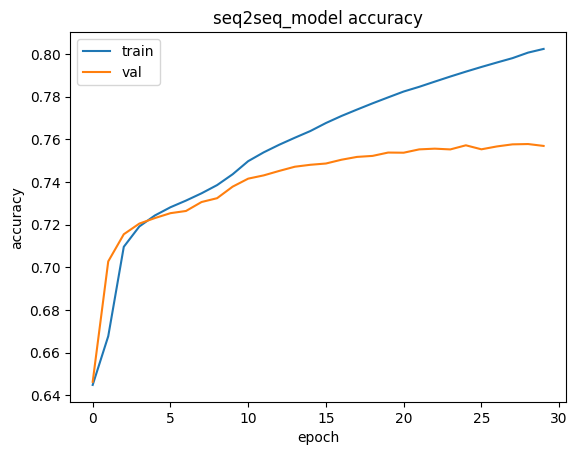

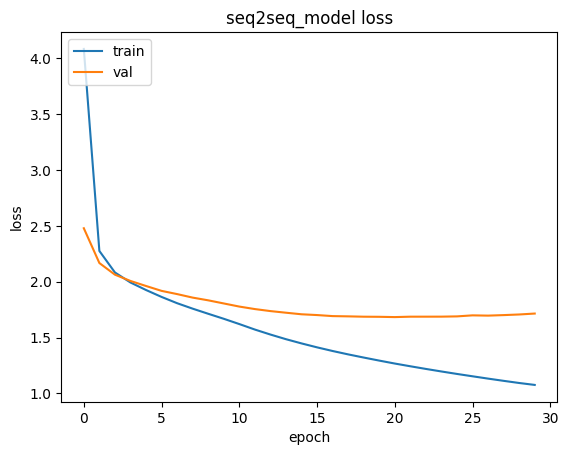

In [93]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(model.name+' accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(model.name+' loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
